In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import keras
from keras.layers import LeakyReLU
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from numpy import vstack
from numpy import ones
from numpy import zeros
from keras.initializers import RandomNormal
from numpy.random import randint
import os
from google.colab import drive
from PIL import UnidentifiedImageError
from numpy import load
from matplotlib import pyplot
from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Activation, Dropout, Concatenate
import tensorflow as tf
import keras
from keras.layers import LeakyReLU
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from numpy import vstack
from numpy import ones
from numpy import zeros
from keras.initializers import RandomNormal
from numpy.random import randint
import matplotlib.pyplot as plt
from numpy import load
from keras.models import Model


In [ ]:
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [ ]:
def load_images(path, size=(256, 512)):
    src_img, targ_img = list(), list()
    for filename in listdir(path):
        try:
            image = load_img(path+'/'+filename, target_size=size)
            pixels = img_to_array(image)
            edge_image, real_image = pixels[:, :256], pixels[:, 256:]
            src_img.append(edge_image)
            targ_img.append(real_image)
        except UnidentifiedImageError as e:
            print(f"Error loading {filename}: {e}")
    return [asarray(src_img), asarray(targ_img)]

path = "/content/drive/MyDrive/facades/train"
print("Changing directory to:", path)
os.chdir(path)
print("Current directory:", os.getcwd())

[src_imageset, targ_imageset] = load_images(path)
print("Loaded:", src_imageset.shape, targ_imageset.shape)

filename = "facades.npz"
savez_compressed(filename, src_imageset, targ_imageset)
print("Saved dataset as", filename)

Changing directory to: /content/drive/MyDrive/facades/train
Current directory: /content/drive/MyDrive/facades/train
Loaded: (401, 256, 256, 3) (401, 256, 256, 3)
Saved dataset as facades.npz


loaded: (401, 256, 256, 3) (401, 256, 256, 3)


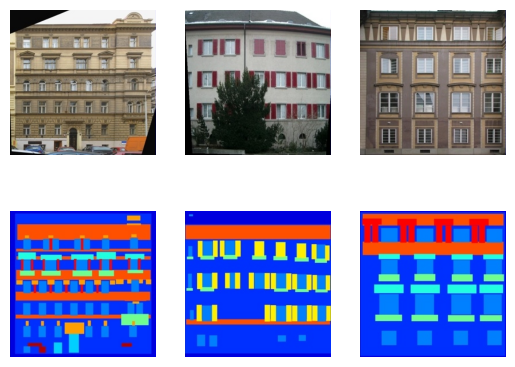

In [ ]:


data = load("facades.npz")
src_image, targ_image = data["arr_0"], data["arr_1"]
print("loaded:", src_image.shape, targ_image.shape)
n=3
for i in range(n):
  pyplot.subplot(2,n,1+i)
  pyplot.axis("off")
  pyplot.imshow(src_image[i].astype("uint8"))

for i in range(n):
  pyplot.subplot(2,n,1+n+i)
  pyplot.axis("off")
  pyplot.imshow(targ_image[i].astype("uint8"))

In [ ]:
def discriminator(image_shape):
  init = RandomNormal(stddev=0.02)
  in_src_image = keras.layers.Input(shape=image_shape)
  in_target_image = keras.layers.Input(shape=image_shape)
  merged = keras.layers.Concatenate()([in_src_image, in_target_image])

  d = keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  d = keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = keras.layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = keras.layers.Activation('sigmoid')(d)
  model = keras.models.Model([in_src_image, in_target_image], patch_out)

  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, Activation, BatchNormalization, LeakyReLU, Concatenate

def encoder_block(input_tensor, n_filters, kernel_size=4, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), strides=(2, 2), padding='same', kernel_initializer=init)(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    return x

def decoder_block(input_tensor, skip_layer, n_filters):
    init = RandomNormal(stddev=0.02)
    x = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Concatenate()([x, skip_layer])
    return x

def generator(input_img=(256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    image = Input(shape=input_img)

    # Contracting Path
    c1 = encoder_block(image, 32, kernel_size=4, batchnorm=False)
    c2 = encoder_block(c1, 64, kernel_size=4, batchnorm=True)
    c3 = encoder_block(c2, 128, kernel_size=4, batchnorm=True)
    c4 = encoder_block(c3, 256, kernel_size=4, batchnorm=True)

    # Expansive Path
    d1 = decoder_block(c4, c3, 128)
    d2 = decoder_block(d1, c2, 64)
    d3 = decoder_block(d2, c1, 32)

    outputs = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(d3)
    outputs = Activation("tanh")(outputs)

    model = Model(inputs=[image], outputs=[outputs])
    return model


In [ ]:
# GAN model, combined discriminator and Generator
def gan_model(generator, discriminator, input_img):
  discriminator.trainable = False
  src_input = keras.layers.Input(shape = input_img)
  gen_output = generator(src_input)
  disc_output = discriminator([src_input, gen_output])
  model = keras.models.Model(inputs=src_input, outputs=[disc_output, gen_output])
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss=["binary_crossentropy", "mae"], optimizer=opt, loss_weights=[1,100])
  return model

In [ ]:
def load_dataset(filename):
  data = load(filename)
  X1, X2 = data["arr_0"], data["arr_1"]
  X1 = (X1 - 127.5)/127.5
  X2 = (X2 - 127.5)/127.5
  return [X1,X2]

In [ ]:
def generate_real_images(dataset, n, patch_shape):
  trainA, trainB = dataset
  ix = randint(0, trainA.shape[0],n)
  X1, X2 = trainA[ix], trainB[ix]
  y = ones((n, patch_shape, patch_shape,1))
  return [X1,X2], y

In [ ]:
def generate_fake_images(model, sample, patch_shape):
  print("number of shape")
  print(sample.shape)
  print("patch shape")
  print(patch_shape)
  X = model.predict(sample)
  print("fake image size")
  print(X.shape)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X,y

In [ ]:
def performance_check(step, model, dataset, n=3):
  [realA, realB], _ = generate_real_images(dataset, n, 1)
  fakeB, _ = generate_fake_images(model, realA, 1)
  realA = (realA+1)/2.0
  realB = (realB+1)/2.0
  fakeB = (fakeB+1)/2.0

# plot real source images
  for i in range(n):
    pyplot.subplot(3, n, 1+i)
    pyplot.axis("off")
    pyplot.imshow(realA[i])

#plot generated target images
  for i in range(n):
    pyplot.subplot(3, n, 1+n+i)
    pyplot.axis("off")
    pyplot.imshow(fakeB[i])

# plot real target images
  for i in range(n):
    pyplot.subplot(3, n, 1+n*2+i)
    pyplot.axis("off")
    pyplot.imshow(realB[i])
  filename1 = 'plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  filename2 = 'model_%6d.h5' % (step+1)
  model.save(filename2)
  print(">saved: %s and %s" % (filename1, filename2))

In [ ]:
def train_gan(disc_model, gen_model, gan_model, dataset, epochs=70, batch=1):
  n_patch = disc_model.output_shape[1]
  trainA, trainB = dataset
  batch_per_epoch = int(len(trainA)/batch)
  print(batch_per_epoch)
  steps = batch_per_epoch*epochs
  print("steps")
  print(steps)

  for i in range(steps):
    print(i)
    [realA, realB], y_real = generate_real_images(dataset, batch, n_patch)
    fakeB, y_fake = generate_fake_images(gen_model, realA, n_patch)
    disc_loss1 = disc_model.train_on_batch([realA, realB], y_real)
    disc_loss2 = disc_model.train_on_batch([realA, fakeB], y_fake)
    gen_loss, _, _ = gan_model.train_on_batch(realA, [y_real, realB])
    print(">%d, d1[%.3f] d2[%.3f] g[%.3f]" %(i+1, disc_loss1, disc_loss2, gen_loss))
    if (i+1) % (batch_per_epoch*10) == 0 :
      performance_check(i, gen_model, dataset)

In [ ]:
dataset = load_dataset('facades.npz')
print("Loaded", dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
disc_model = discriminator(image_shape)
gen_model = generator(image_shape)
gan_model = gan_model(gen_model, disc_model, image_shape)
train_gan(disc_model, gen_model, gan_model, dataset)

Loaded (401, 256, 256, 3) (401, 256, 256, 3)


Streaming output truncated to the last 5000 lines.
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 50ms/step
fake image size
(1, 256, 256, 3)
>3456, d1[0.000] d2[0.046] g[48.907]
3456
number of shape
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 55ms/step
fake image size
(1, 256, 256, 3)
>3457, d1[0.000] d2[0.015] g[20.086]
3457
number of shape
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 51ms/step
fake image size
(1, 256, 256, 3)
>3458, d1[0.000] d2[0.010] g[32.434]
3458
number of shape
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 51ms/step
fake image size
(1, 256, 256, 3)
>3459, d1[0.000] d2[0.006] g[24.843]
3459
number of shape
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 50ms/step
fake image size
(1, 256, 256, 3)
>3460, d1[0.004] d2[0.007] g[26.602]
3460
number of shape
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
patch shape
16
1/1 [==============================] - 0s 51ms/step
fake image size
(1, 256, 256, 3)
>5993, d1[0.027] d2[0.000] g[29.696]
5993
number of shape
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 50ms/step
fake image size
(1, 256, 256, 3)
>5994, d1[0.014] d2[0.001] g[24.797]
5994
number of shape
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 50ms/step
fake image size
(1, 256, 256, 3)
>5995, d1[0.001] d2[0.000] g[45.291]
5995
number of shape
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 51ms/step
fake image size
(1, 256, 256, 3)
>5996, d1[0.038] d2[0.000] g[19.291]
5996
number of shape
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 48ms/step
fake image size
(1, 256, 256, 3)
>5997, d1[1.728] d2[0.157] g[15.839]
5997
number of shape
(1, 256, 256, 3)
patch shape
16
1/1 [==============================] - 0s 49ms/step
fake im

In [ ]:
#Loading the dataset and spliting it into edge images and real images
def load_images(path, size=(256,512)):
  src_img, targ_img = list(), list()
  for filename in listdir(path):
    image = load_img(path+'/'+filename, target_size=size)
    pixels = img_to_array(image)
    edge_image, real_image = pixels[:,:256], pixels[:,256:]
    src_img.append(edge_image)
    targ_img.append(real_image)
  return [asarray(src_img), asarray(targ_img)]

path = "/content/drive/MyDrive/facades/val"
print("Changing directory to:", path)
os.chdir(path)
print("Current directory:", os.getcwd())
[src_imageset, targ_imageset] = load_images(path)
print("loaded:", src_imageset.shape, targ_imageset.shape)
filename = "facades.npz"
savez_compressed(filename, src_imageset, targ_imageset)
print("saved dataset", filename)


In [ ]:
data = load("facades.npz")
src_image, targ_image = data["arr_0"], data["arr_1"]
src_image = (src_image-127.5)/127.5
targ_image = (targ_image-127.5)/127.5
print("loaded", src_image.shape, targ_image.shape)
gen_image = tf.keras.saving.load_model("/content/drive/MyDrive/facades/train/model_  4000.h5")

images = vstack((src_image, gen_image, targ_image))
#scaling [-1,1] to [0,1]
images = (images+1)/2.0
titles = ["Source", "Generated", "Expected"]
for i in range(len(images)):
  pyplot.subplot(1,3,1+i)
  pyplot.axis("off")
  pypolt.imshow(images[i])
  pypolt.title(titles[i])
pyplot.show()

